In [1]:
using DifferentialEquations
using ModelingToolkit
using LinearAlgebra
using Plots
using Colors
using Statistics
using Sundials

# Classic Yeast model
### Fast, single polarity
### Spatially homogenous RhoD, all other membrane associated.

In [32]:
# Generate the constants
N = 100
Ax = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1])) # Stencil for diffusion.
Ax[1,end] = 1.0    # Modifications for periodic boundaries.
Ax[end,1] = 1.0    # Modifications for periodic boundaries.Ay = copy(Ax)
Ax[1,end] = 1.0
Ax[end,1] = 1.0
Ax = Ax/0.1^2  

r0 = zeros(100,2)
r0[:,1] .= 0.2.*(rand.() .+1)
r0[:,2] .= 0.8.*(rand.() .+1)
E = 1

# Dummy parameters used only locally in fxn but passed to specify scope, or something..
tAx = zeros(N)
Dt = zeros(N)
R1 = zeros(N)

100-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [33]:
function yeast_fast!(dr,r,p,t)
  Ka, Ki, D1, tAx,Dt, R1 = p
  rhoT = @view r[:,1]
  rhoD = @view r[:,2]
  rhoD .= mean(rhoD)
  dgtp = @view dr[:,1]
  dgdp = @view dr[:,2]
  mul!(tAx,Ax,rhoT)
  @. Dt = D1*(tAx)
  @. R1 = Ka*rhoT^2*rhoD - Ki*rhoT
  #  @. R1 = Ka*rhoT^2*rhoD - Ki*rhoT
  # Alternative nonlinear pos feedback
  @. dgtp = Dt + R1
  @. dgdp = - R1
  end

yeast_fast! (generic function with 1 method)

In [34]:
p = (10,1.0,0.05,tAx,Dt,R1)
# p = (10,0.1,0.005,Ayt,tAx,Dt,R1)
# params for alt pos fb equation
yf = ODEProblem(yeast_fast!,r0,(0.0,600),p)
sol_yf = solve(yf,CVODE_BDF(linear_solver=:GMRES),saveat=1)

retcode: Success
Interpolation: 1st order linear
t: 601-element Vector{Float64}:
   0.0
   1.0
   2.0
   3.0
   4.0
   5.0
   6.0
   7.0
   8.0
   9.0
   ⋮
 592.0
 593.0
 594.0
 595.0
 596.0
 597.0
 598.0
 599.0
 600.0
u: 601-element Vector{Matrix{Float64}}:
 [0.33418848904543497 0.9038160589474992; 0.31174015701782826 1.0236054489923194; … ; 0.2865173353099973 1.4868095248657678; 0.32312000990916534 1.0777105359126389]
 [0.8252742761980977 0.61164670094707; 0.7511032548862129 0.7740670233261899; … ; 1.0281262312533368 0.6106615172014966; 0.9138877155483114 0.5775638689428566]
 [0.4687809528537026 1.1028846873250242; 0.41225108278040057 1.226838331978121; … ; 0.6645318920883772 1.2123260664744357; 0.551284071146334 1.1189002771000132]
 [0.23187251502123912 1.4259522559975526; 0.20251912308343561 1.5111955173149916; … ; 0.3200515437725071 1.657464173077556; 0.27093478885805067 1.4953239918413999]
 [0.10264647151936425 1.5830623662524883; 0.09073175741583259 1.649335191640448; … ; 0.1345

In [35]:
# p = (50,5.0,0.005,Ayt,tAx,Dt,R1)
# Increasing off rate results in smaller and more concentrated patch.

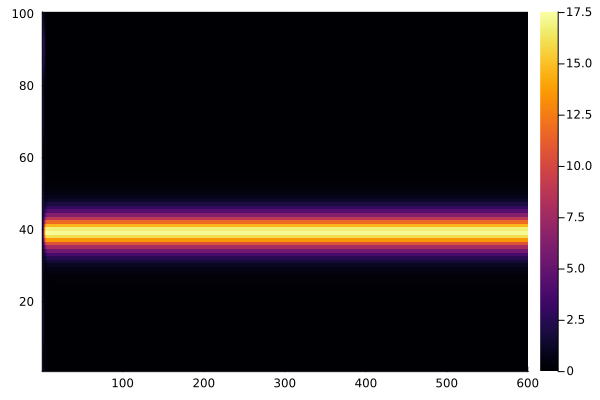

In [36]:
X = zeros(100,600)
for i in 1:600
    tmp = sol_yf[i][:,1]
    X[:,i]=tmp
end
Plots.heatmap(X)

# Yeast model with saturation
### Multiple poles possible
### Spatially homogenous RhoD, all other membrane associated.

In [58]:
function yeast_saturating!(dr,r,p,t)
  Ka, Ki, D1, tAx,Dt, R1 = p
  rhoT = @view r[:,1]
  rhoD = @view r[:,2]
  rhoD .= mean(rhoD)
  dgtp = @view dr[:,1]
  dgdp = @view dr[:,2]
  mul!(tAx,Ax,rhoT)
  @. Dt = D1*(tAx)
  @. R1 = Ka*(rhoT/(1+rhoT))*rhoT*rhoD - Ki*rhoT
  #  @. R1 = Ka*rhoT^2*rhoD - Ki*rhoT
  # Alternative nonlinear pos feedback
  @. dgtp = Dt + R1
  @. dgdp = - R1
  end

yeast_saturating! (generic function with 1 method)

In [59]:
p = (10,.1,0.005,tAx,Dt,R1)
ys = ODEProblem(yeast_saturating!,r0,(0.0,600),p)
sol_ys = solve(ys,CVODE_BDF(linear_solver=:GMRES),saveat=1)

retcode: Success
Interpolation: 1st order linear
t: 601-element Vector{Float64}:
   0.0
   1.0
   2.0
   3.0
   4.0
   5.0
   6.0
   7.0
   8.0
   9.0
   ⋮
 592.0
 593.0
 594.0
 595.0
 596.0
 597.0
 598.0
 599.0
 600.0
u: 601-element Vector{Matrix{Float64}}:
 [0.33418848904543497 0.9038160589474992; 0.31174015701782826 1.0236054489923194; … ; 0.2865173353099973 1.4868095248657678; 0.32312000990916534 1.0777105359126389]
 [1.5392325370215287 -0.08801071276843489; 1.3443262440739119 0.1681791644509018; … ; 1.3829140913460893 0.2547284135862249; 1.497636090890185 0.010439065212646136]
 [1.4623813298072412 -0.08857682736029741; 1.3595227766763736 0.17326304728808228; … ; 1.4385712827842148 0.257391333257509; 1.470873518026656 0.010421358040907599]
 [1.4263237406945162 -0.08483213561312228; 1.3571169094831812 0.1800027772915753; … ; 1.4469309425089962 0.26103995161020427; 1.4508514737454175 0.013483818496105056]
 [1.4043564281768066 -0.08020832107222745; 1.3440681428366692 0.186899316477215

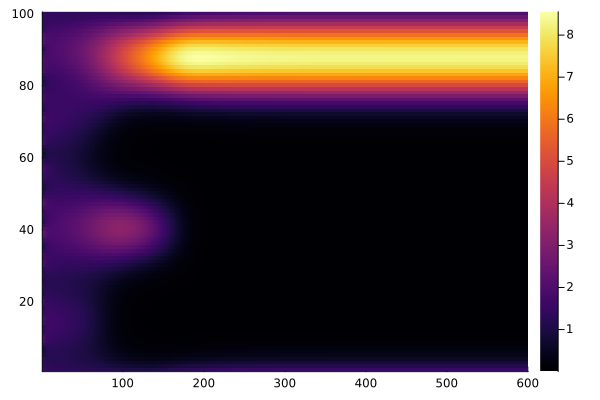

In [60]:
X = zeros(100,600)
for i in 1:600
    tmp = sol_ys[i][:,1]
    X[:,i]=tmp
end
Plots.heatmap(X)

# Yeast model with slowed RhoD (membrane bound)
### Very long convergence
### All species membrane bound

In [42]:
dAx = zeros(N)
Dd = zeros(N)

function yeast_slowed!(dr,r,p,t)
    Ka, Ki, D1, D2, Ayt,tAx,Dt,Ayd,dAx,Dd, R1 = p
    rhoT = @view r[:,:,1]
    rhoD = @view r[:,:,2]
    dgtp = @view dr[:,:,1]
    dgdp = @view dr[:,:,2]
    mul!(Ayt,Ay,rhoT)
    mul!(tAx,rhoT,Ax)
    mul!(Ayd,Ay,rhoD)
    mul!(dAx,rhoD,Ax)
    @. Dt = D1*(Ayt + tAx)
    @. Dd = D2*(Ayd + dAx)
    @. R1 = Ka*(rhoT/(rhoT+1))*rhoT*rhoD - Ki*rhoT
    @. dgtp = Dt + R1
    @. dgdp = Dd - R1
    end

yeast_slowed! (generic function with 1 method)

In [68]:
dAx = zeros(N)
Dd = zeros(N)

function yeast_slowed!(dr,r,p,t)
    Ka, Ki, D1, D2, tAx, dAx, Dt, Dd, R1 = p
    rhoT = @view r[:,1]
    rhoD = @view r[:,2]
    dgtp = @view dr[:,1]
    dgdp = @view dr[:,2]
    mul!(tAx,Ax,rhoT)
    mul!(dAx,Ax,rhoD)
    @. Dt = D1*(tAx)
    @. Dd = D2*(dAx)
    @. R1 = Ka*rhoT^2*rhoD - Ki*rhoT
    @. dgtp = Dt + R1
    @. dgdp = Dd - R1
    end


yeast_slowed! (generic function with 1 method)

In [151]:
p = (1,.1,0.005, 6, tAx, dAx, Dt ,Dd, R1)
ysl = ODEProblem(yeast_slowed!,r0,(0.0,1800),p)
sol_ysl = solve(ysl,CVODE_BDF(linear_solver=:GMRES),saveat=1)

retcode: Success
Interpolation: 1st order linear
t: 1801-element Vector{Float64}:
    0.0
    1.0
    2.0
    3.0
    4.0
    5.0
    6.0
    7.0
    8.0
    9.0
    ⋮
 1792.0
 1793.0
 1794.0
 1795.0
 1796.0
 1797.0
 1798.0
 1799.0
 1800.0
u: 1801-element Vector{Matrix{Float64}}:
 [0.33418848904543497 0.9038160589474992; 0.31174015701782826 1.0236054489923194; … ; 0.2865173353099973 1.4868095248657678; 0.32312000990916534 1.0777105359126389]
 [0.446708053405153 1.0955662450229025; 0.40974806919784834 1.0961558347993439; … ; 0.4201295460743493 1.0944306178922203; 0.44025993952500053 1.0949961822553165]
 [0.660232946779163 0.8527205861734045; 0.6094807380575864 0.8537720188071326; … ; 0.653214569848552 0.850443083999175; 0.6666696996879227 0.8516065114917964]
 [0.9787770848353885 0.4264587732551042; 0.8963036299894013 0.4286476825880018; … ; 1.0067996655551847 0.421455884826215; 1.010560532645249 0.42405003944463054]
 [1.1306189930915 0.13108775502328968; 1.0324121059710796 0.13215864030

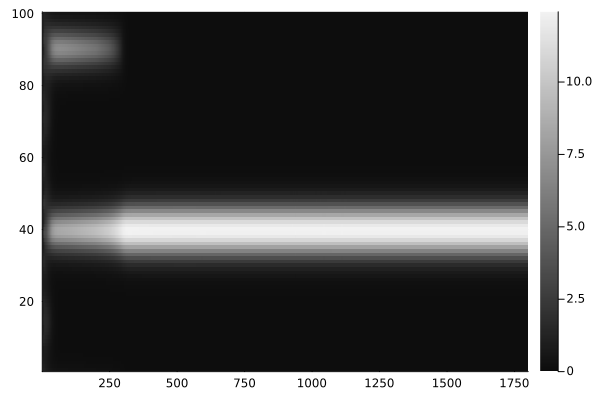

In [152]:
X = zeros(100,1800)
for i in 1:1800
    tmp = sol_ysl[i][:,1]
    X[:,i]=tmp
end
Plots.heatmap(X, c = :grays)

In [157]:
p = (1,.1,0.0005, .6, tAx, dAx, Dt ,Dd, R1)
ysl = ODEProblem(yeast_slowed!,r0,(0.0,1800),p)
sol_ysl = solve(ysl,CVODE_BDF(linear_solver=:GMRES),saveat=1)

retcode: Success
Interpolation: 1st order linear
t: 1801-element Vector{Float64}:
    0.0
    1.0
    2.0
    3.0
    4.0
    5.0
    6.0
    7.0
    8.0
    9.0
    ⋮
 1792.0
 1793.0
 1794.0
 1795.0
 1796.0
 1797.0
 1798.0
 1799.0
 1800.0
u: 1801-element Vector{Matrix{Float64}}:
 [0.33418848904543497 0.9038160589474992; 0.31174015701782826 1.0236054489923194; … ; 0.2865173353099973 1.4868095248657678; 0.32312000990916534 1.0777105359126389]
 [0.47299724079988076 1.0784195363853848; 0.4220555445818556 1.0782306257466243; … ; 0.3876033449466258 1.0796500294542164; 0.45161765091368794 1.0790349075316614]
 [0.7510213371441499 0.8310942467534398; 0.6201066625878829 0.83571606172932; … ; 0.5602461701905579 0.8229430529982164; 0.6960260244544433 0.8271988919923875]
 [1.2001262285533605 0.38656822570596694; 0.8852612051651685 0.3882771378668165; … ; 0.7825676714654584 0.3801791592109968; 1.0591626511074665 0.384449752666811]
 [1.4090291845149876 0.10431940737199771; 0.9815053940864675 0.10226

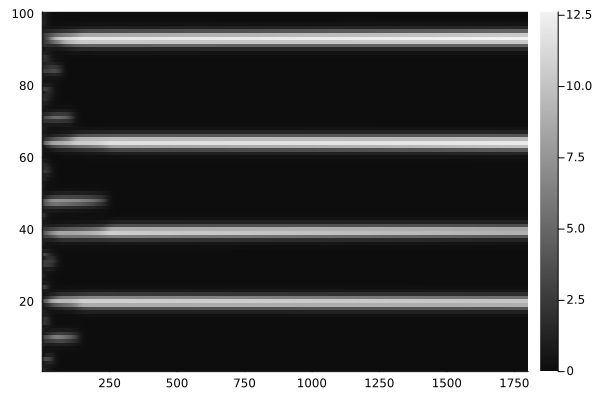

In [158]:
X = zeros(100,1800)
for i in 1:1800
    tmp = sol_ysl[i][:,1]
    X[:,i]=tmp
end
Plots.heatmap(X, c = :grays)

In [262]:
dAx = zeros(N)
Dd = zeros(N)
total = sum(r0)
function yeast_slowRand!(dr,r,p,t)
    Ka, Ki, D1, D2, tAx, dAx, Dt, Dd, R1 = p
    rhoT = @view r[:,1]
    rhoD = @view r[:,2]
    dgtp = @view dr[:,1]
    dgdp = @view dr[:,2]
    mul!(tAx,Ax,rhoT)
    mul!(dAx,Ax,rhoD)
    @. Dt = D1*(tAx)
    @. Dd = D2*(dAx)
    @. R1 = Ka*rhoT^2*rhoD - Ki*rhoT*(rand()+.5)
    @. dgtp = Dt + R1
    @. dgdp = Dd - R1
    end


yeast_slowRand! (generic function with 1 method)

In [264]:
p = (1,.1,0.005, 6, tAx, dAx, Dt ,Dd, R1)
ysr = ODEProblem(yeast_slowRand!,r0,(0.0,1800),p)
sol_ysr = solve(ysl,CVODE_BDF(linear_solver=:GMRES),saveat=1)

retcode: MaxIters
Interpolation: 1st order linear
t: 28-element Vector{Float64}:
  0.0
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
  ⋮
 19.0
 20.0
 21.0
 22.0
 23.0
 24.0
 25.0
 26.0
 26.309149085846762
u: 28-element Vector{Matrix{Float64}}:
 [0.33418848904543497 0.9038160589474992; 0.31174015701782826 1.0236054489923194; … ; 0.2865173353099973 1.4868095248657678; 0.32312000990916534 1.0777105359126389]
 [0.44924131158123504 1.095569092947433; 0.4106788139747102 1.096100446455574; … ; 0.4200249527702118 1.0945408872603422; 0.4427856280005778 1.095056628923432]
 [0.6653551852330942 0.8513818511608011; 0.6149202585273494 0.8524900301548605; … ; 0.6545593640452729 0.8489599615533298; 0.6717508747456474 0.8501915070044542]
 [0.9714637324803218 0.4229635614112987; 0.9079083339351004 0.4250970362958714; … ; 1.0103681656204677 0.4180087833725956; 1.0185784866623702 0.4205847903142839]
 [1.1264183436458817 0.13006617802745288; 1.0365846489149781 0.13112054027493164; … ; 1.19485338704

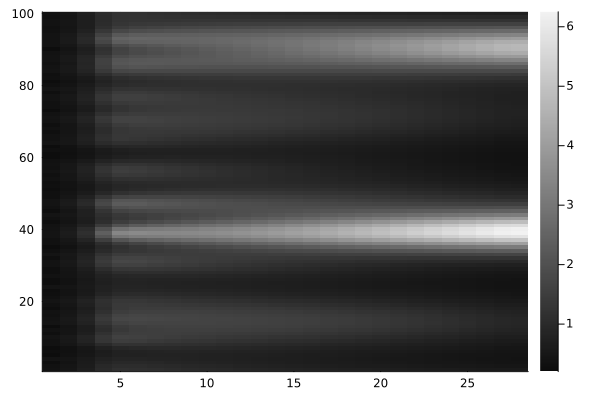

In [265]:
n=length(sol_ysr)
X = zeros(100,n)
for i in 1:n
    tmp = sol_ysr[i][:,1]
    X[:,i]=tmp
end
Plots.heatmap(X, c = :grays)